# Inicializacion

## Objetivo

Luego de realizado el primer modelo de machine learning usando Regresion Logistica con todas las features, queremos realizar un modelo un poco mas sofisticado utilizando el modelo **XGBoost**.

El objetivo del modelo de ML es predecir si un paciente tiene una enfermedad cardiovascular a partir de las siguientes features:
* Age: edad del paciente [años]

* Sex: sexo del paciente [M: Masculino, F: Femenino]

* ChestPainType: tipo de dolor en el pecho [TA: Angina Típica, ATA: Angina Atípica, NAP: Dolor No Anginoso, ASY: Asintomático]

* RestingBP: presión arterial en reposo [mm Hg]

* Cholesterol: colesterol sérico [mg/dl]

* FastingBS: glucemia en ayunas [1: si FastingBS > 120 mg/dl, 0: en caso contrario]

* RestingECG: resultados del electrocardiograma en reposo [Normal: Normal, ST: anomalía de la onda ST-T (inversiones de la onda T y/o elevación o depresión del ST > 0.05 mV), LVH: posible o definitiva hipertrofia ventricular izquierda según los criterios de Estes]

* MaxHR: frecuencia cardíaca máxima alcanzada [valor numérico entre 60 y 202]

* ExerciseAngina: angina inducida por ejercicio [Y: Sí, N: No]

* Oldpeak: oldpeak = ST [valor numérico medido como depresión del segmento ST]

* ST_Slope: pendiente del segmento ST durante el ejercicio máximo [Up: ascendente, Flat: plana, Down: descendente]

* HeartDisease: clase de salida [1: enfermedad cardíaca, 0: Normal]

## Librerias necesarias

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials




## Autenticacion con Google Drive y descarga del archivo

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded_train = drive.CreateFile({'id':"1J901qWCpTLIYVJxWhb7PNuBtgNOc937I"})
downloaded_test = drive.CreateFile({'id': "1gFgeQ4IW7XW0iD3BrC0Mns7jGYjV7rXn"})

downloaded_train.GetContentFile('heart_train.csv')
downloaded_test.GetContentFile('heart_test.csv')

In [ ]:
heart_test = pd.read_csv('heart_test.csv') # Este solo se usara para predecir para la competencia
heart_test.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,46,M,ASY,115,0,0,Normal,113,Y,1.5,Flat
1,58,M,NAP,132,224,0,LVH,173,N,3.2,Up
2,60,M,ASY,125,258,0,LVH,141,Y,2.8,Flat


In [ ]:
heart_data = pd.read_csv('heart_train.csv')
heart_data.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat,1
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up,0
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat,1


# XGBoost

## Separacion de la variable a predecir

Primero debemos separar el target de las demas variables.

In [ ]:
y = heart_data.HeartDisease
X = heart_data.drop("HeartDisease", axis = 1)

In [ ]:
y

,HeartDisease
0,1
1,0
2,1
3,1
4,1
...,...
729,1
730,0
731,1
732,0


In [ ]:
X

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat
3,47,M,ASY,160,0,0,Normal,124,Y,0.0,Flat
4,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat
...,...,...,...,...,...,...,...,...,...,...,...
729,51,M,NAP,135,160,0,Normal,150,N,2.0,Flat
730,46,M,NAP,120,230,0,Normal,150,N,0.0,Up
731,59,M,ASY,122,233,0,Normal,117,Y,1.3,Down
732,61,M,ASY,125,292,0,ST,115,Y,0.0,Up


## Separacion entre train y validation

En este caso podemos realizar una separacion aleatoria ya que no tenemos features cronologicas.

Ademas, utilizamos una semilla para poder reproducir los resultados.

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=123)
X_test = heart_test # Este se usa para predecir para la competencia

In [ ]:
X_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
124,36,M,ATA,120,267,0,Normal,160,N,3.0,Flat
328,56,M,ASY,150,230,0,ST,124,Y,1.5,Flat
708,51,M,ASY,140,261,0,LVH,186,Y,0.0,Up
724,63,M,ASY,130,330,1,LVH,132,Y,1.8,Up
598,51,M,ASY,130,0,1,ST,163,N,0.0,Flat
...,...,...,...,...,...,...,...,...,...,...,...
98,57,M,NAP,150,126,1,Normal,173,N,0.2,Up
322,58,M,NAP,112,230,0,LVH,165,N,2.5,Flat
382,53,M,ATA,120,0,0,Normal,95,N,0.0,Flat
365,54,M,ASY,125,216,0,Normal,140,N,0.0,Flat


In [ ]:
X_validation

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
169,73,F,NAP,160,0,0,ST,121,N,0.0,Up
273,46,M,ASY,134,310,0,Normal,126,N,0.0,Flat
653,66,M,ASY,112,261,0,Normal,140,N,1.5,Up
579,61,F,ATA,140,298,1,Normal,120,Y,0.0,Up
692,59,M,ASY,140,274,0,Normal,154,Y,2.0,Flat
...,...,...,...,...,...,...,...,...,...,...,...
538,61,M,ATA,139,283,0,Normal,135,N,0.3,Up
634,70,M,NAP,160,269,0,Normal,112,Y,2.9,Flat
545,63,M,ASY,150,0,0,Normal,86,Y,2.0,Flat
408,62,M,ASY,120,220,0,ST,86,N,0.0,Up


## Encoding de features categoricas

### Sex

En este caso como la variable 'Sex' solo tiene 2 valores posibles (M o F) podemos utilizar el metodo **One Hot Encoding**, que agrega una columna a nuestro dataset para cada valor posible de la feature.

Ademas, podemos dropear alguno de los valores de la feature (M o F) para que quede solamente una columna booleana y optimizar aun mas el encoding.

In [ ]:
ohe_sex = OneHotEncoder(drop='first') # Dropea uno de los valores de la feature 'Sex'

encoded_sex = ohe_sex.fit_transform(X_train[['Sex']]).toarray().astype(int)
encoded_sex_validation = ohe_sex.transform(X_validation[['Sex']]).toarray().astype(int)
encoded_sex_test = ohe_sex.transform(X_test[['Sex']]).toarray().astype(int)

# fit_transform aprende de los valores presentes en train de la columna Sex
# transform para evitar que posibles valores nuevos de Sex que aparecen en validation se introduzcan para entrenar el modelo

In [ ]:
X_train.Sex = encoded_sex
X_validation.Sex = encoded_sex_validation
X_test.Sex = encoded_sex_test

In [ ]:
X_train.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
124,36,1,ATA,120,267,0,Normal,160,N,3.0,Flat
328,56,1,ASY,150,230,0,ST,124,Y,1.5,Flat
708,51,1,ASY,140,261,0,LVH,186,Y,0.0,Up


### ChestPainType

In [ ]:
X_train.ChestPainType.value_counts()

,count
ChestPainType,
ASY,332
NAP,116
ATA,105
TA,34


Tenemos 4 valores posibles, podemos usar OneHotEncoding. En este caso no podemos simplemente reemplazar por la columna original por que se nos van a generear 3 columnas nuevas.

In [ ]:
ohe_cpt = OneHotEncoder(drop='first')

encoded_cpt = ohe_cpt.fit_transform(X_train[['ChestPainType']]).toarray().astype(int)
encoded_cpt_validation = ohe_cpt.transform(X_validation[['ChestPainType']]).toarray().astype(int)
encoded_cpt_test = ohe_cpt.transform(X_test[['ChestPainType']]).toarray().astype(int)

Generamos tres dataframes para unir a los datasets de train, validation y test.

In [ ]:
encoded_cpt_df = pd.DataFrame(
    encoded_cpt,
    columns=ohe_cpt.get_feature_names_out(['ChestPainType']),
    index=X_train.index
)

encoded_cpt_validation_df = pd.DataFrame(
    encoded_cpt_validation,
    columns=ohe_cpt.get_feature_names_out(['ChestPainType']),
    index=X_validation.index
)

encoded_cpt_test_df = pd.DataFrame(
    encoded_cpt_test,
    columns=ohe_cpt.get_feature_names_out(['ChestPainType']),
    index=X_test.index
)

In [ ]:
X_train = X_train.drop(columns=['ChestPainType']).join(encoded_cpt_df)
X_validation = X_validation.drop(columns=['ChestPainType']).join(encoded_cpt_validation_df)
X_test = X_test.drop(columns=['ChestPainType']).join(encoded_cpt_test_df)

In [ ]:
X_train.head(3)

,Age,Sex,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
124,36,1,120,267,0,Normal,160,N,3.0,Flat,1,0,0
328,56,1,150,230,0,ST,124,Y,1.5,Flat,0,0,0
708,51,1,140,261,0,LVH,186,Y,0.0,Up,0,0,0


### RestingECG

In [ ]:
X_train.RestingECG.value_counts()

,count
RestingECG,
Normal,356
LVH,126
ST,105


En este caso como tenemos 3 valores posibles, podemos usar Mean Encoding. Usaremos la libreria TargetEncoding de sklearn.

Mean Encoding agrega una columna que contiene el promedio del label para cada valor de ChestPainType.

Hay que tener cuidado porque se puede filtrar informacion.

In [ ]:
te_recg = TargetEncoder(random_state=123)

In [ ]:
encoded_recg = te_recg.fit_transform(X_train[['RestingECG']], y_train)
encoded_recg_validation = te_recg.transform(X_validation[['RestingECG']])
encoded_recg_test = te_recg.transform(X_test[['RestingECG']])

In [ ]:
encoded_recg_df = pd.DataFrame(
    encoded_recg,
    columns=te_recg.get_feature_names_out(['RestingECG']),
    index=X_train.index
)

encoded_recg_validation_df = pd.DataFrame(
    encoded_recg_validation,
    columns=te_recg.get_feature_names_out(['RestingECG']),
    index=X_validation.index
)

encoded_recg_test_df = pd.DataFrame(
    encoded_recg_test,
    columns=te_recg.get_feature_names_out(['RestingECG']),
    index=X_test.index
)

In [ ]:
X_train = X_train.drop(columns=['RestingECG']).join(encoded_recg_df)
X_validation = X_validation.drop(columns=['RestingECG']).join(encoded_recg_validation_df)
X_test = X_test.drop(columns=['RestingECG']).join(encoded_recg_test_df)

In [ ]:
X_train.head(3)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG
124,36,1,120,267,0,160,N,3.0,Flat,1,0,0,0.537320
328,56,1,150,230,0,124,Y,1.5,Flat,0,0,0,0.639844
708,51,1,140,261,0,186,Y,0.0,Up,0,0,0,0.617320


### ExerciseAngina

In [ ]:
X_train.ExerciseAngina.value_counts()

,count
ExerciseAngina,
N,340
Y,247


En este caso, como es una feature booleana podemos realizar el mismo proceso que hicimos con la feature 'Sex'.

In [ ]:
ohe_exa = OneHotEncoder(drop='first')

encoded_exa = ohe_exa.fit_transform(X_train[['ExerciseAngina']]).toarray().astype(int)
encoded_exa_validation = ohe_exa.transform(X_validation[['ExerciseAngina']]).toarray().astype(int)
encoded_exa_test = ohe_exa.transform(X_test[['ExerciseAngina']]).toarray().astype(int)

In [ ]:
X_train.ExerciseAngina = encoded_exa
X_validation.ExerciseAngina = encoded_exa_validation
X_test.ExerciseAngina = encoded_exa_test

In [ ]:
X_train.head(3)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG
124,36,1,120,267,0,160,0,3.0,Flat,1,0,0,0.537320
328,56,1,150,230,0,124,1,1.5,Flat,0,0,0,0.639844
708,51,1,140,261,0,186,1,0.0,Up,0,0,0,0.617320


### ST_Slope

In [ ]:
X_train.ST_Slope.value_counts()

,count
ST_Slope,
Flat,305
Up,238
Down,44


Nuevamente tenemos 3 valores posibles para 'ST_Slope', por lo que realizamos el mismo proceso que para las features 'RestingECG' y 'ChestPainType'.

In [ ]:
ohe_sts = OneHotEncoder(drop='first')

encoded_sts = ohe_sts.fit_transform(X_train[['ST_Slope']]).toarray().astype(int)
encoded_sts_validation = ohe_sts.transform(X_validation[['ST_Slope']]).toarray().astype(int)
encoded_sts_test = ohe_sts.transform(X_test[['ST_Slope']]).toarray().astype(int)

In [ ]:
encoded_sts_df = pd.DataFrame(
    encoded_sts,
    columns=ohe_sts.get_feature_names_out(['ST_Slope']),
    index=X_train.index
)

encoded_sts_validation_df = pd.DataFrame(
    encoded_sts_validation,
    columns=ohe_sts.get_feature_names_out(['ST_Slope']),
    index=X_validation.index
)

encoded_sts_test_df = pd.DataFrame(
    encoded_sts_test,
    columns=ohe_sts.get_feature_names_out(['ST_Slope']),
    index=X_test.index
)

In [ ]:
X_train = X_train.drop(columns=['ST_Slope']).join(encoded_sts_df)
X_validation = X_validation.drop(columns=['ST_Slope']).join(encoded_sts_validation_df)
X_test = X_test.drop(columns=['ST_Slope']).join(encoded_sts_test_df)

In [ ]:
X_train.head(3)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG,ST_Slope_Flat,ST_Slope_Up
124,36,1,120,267,0,160,0,3.0,1,0,0,0.537320,1,0
328,56,1,150,230,0,124,1,1.5,0,0,0,0.639844,1,0
708,51,1,140,261,0,186,1,0.0,0,0,0,0.617320,0,1


In [ ]:
X_test.head(3)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG,ST_Slope_Flat,ST_Slope_Up
0,46,1,115,0,0,113,1,1.5,0,0,0,0.547852,1,0
1,58,1,132,224,0,173,0,3.2,0,1,0,0.610892,0,1
2,60,1,125,258,0,141,1,2.8,0,0,0,0.610892,1,0


## Creacion del modelo y prediccion

Hacemos la busqueda de hiper-parametros utilizando el alogitmo de XGBoost, optimizado para la metrica de *accuracy* (cuantas veces nuestro modelo predijo bien).

Los hiper-parametros analizados son:
* eta/learning_rate: factor de reduccion del peso de cada feature en cada paso
* max_depth: la profundidad maxima de cada arbol.
* subsample: fracción de los datos de entrenamiento que se usan para entrenar cada arbol
* colsample_bytree: porcentaje de columnas que se usan al construir cada arbol.
* lambda: regularización L2 sobre los pesos
* alpha: regularización L1
* n_estimators: cantidad de árboles que se construyen
* gamma: umbral mínimo de ganancia que debe tener una partición (split) para que se haga

In [ ]:
xg = XGBClassifier(random_state=123)

In [ ]:
params = {
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [2, 4, 6],
    'subsample': [0.1, 0.2, 0.5, 0.8],
    'colsample_bytree': [0.6, 0.8, 1],
    'lambda': [5, 10, 15],
    'alpha': [5, 10, 15],
    'n_estimators': [25, 50, 100, 200, 300],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

In [ ]:
rs = RandomizedSearchCV(xg, param_distributions=params, n_iter=50, random_state=123, scoring='accuracy')

In [ ]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=123, ...),
                   n_iter=50,
                   param_distributions={'alpha': [5, 10, 15],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'lambda': [5, 10, 15],
                                        'max_depth': [2, 4, 6],
                                        'n_estimators': [25, 50, 100, 200, 300],
                                        'subsample': [0.1, 0.2, 0.5, 0.8]},
                   random_state=123, scoring='accuracy')

Vemos que los hiperparametros optimos encontrados utilizando RandomSearch son los siguientes:

In [ ]:
rs.best_params_

{'subsample': 0.8,
 'n_estimators': 200,
 'max_depth': 6,
 'lambda': 5,
 'gamma': 0.3,
 'eta': 0.3,
 'colsample_bytree': 0.6,
 'alpha': 5}

In [ ]:
model = rs.best_estimator_

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(alpha=5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=5,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200, ...)

Una vez ya construido el modelo, podemos usar el set de validacion para predecir.

In [ ]:
y_pred = model.predict(X_validation)

## Evaluacion del modelo

### Matriz de confusion

La matriz de confusion es util para observar que tipos de errores hizo nuestro modelo al predecir.

In [ ]:
y_validation = y_validation.astype(int)

In [ ]:
cm = confusion_matrix(y_validation, y_pred)
cm

array([[67, 16],
       [ 6, 58]])

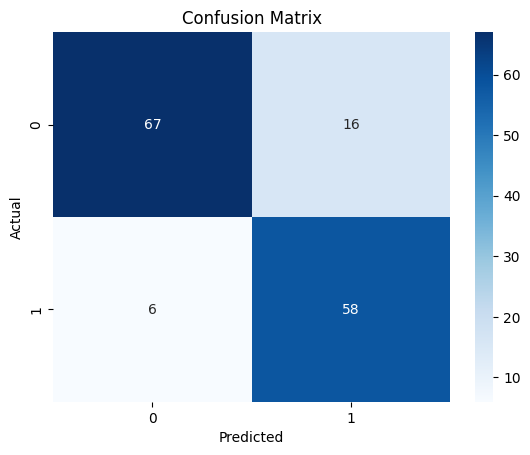

In [ ]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Observamos que nuestro modelo hizo 23 predicciones erroneas, y de estas:
* 6 falsos negativos, este es el error que no queremos ya que en nuestro contexto le estariamos diciendo al paciente que no tiene una enfermedad cardiaca cuando si la tiene.
* 17 falsos positivos, en nuestro contexto este error es menos grave, ya que a lo sumo el paciente se lleva un susto de pensar que tiene una enfermedad que en realidad no tiene.

### Feature Importance

Utilizamos la libreria de xgboost.

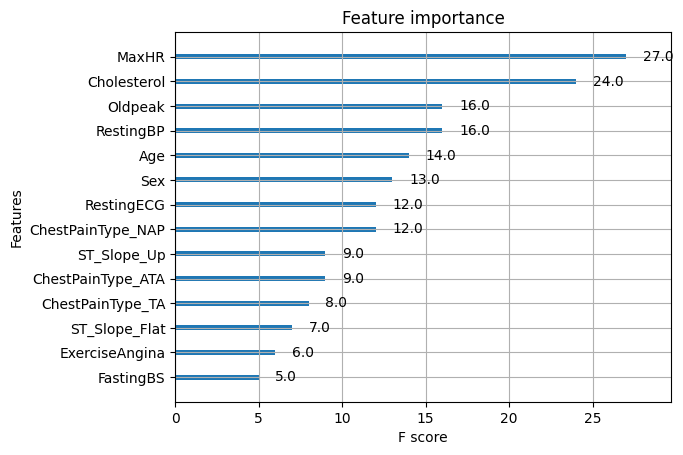

In [ ]:
xgb.plot_importance(model)
plt.show()

El feature importance para el modelo de XGBoost se ve muy distinto al calculado para el modelo de Regresion Logistica:
* En el de Regresion Logistica, el modelo habia inferido que las features mas importantes eran las de ChestPainType y ST_Slope, que en XGBoost no les dio mucha importancia.
* En este caso, el modelo infirió como features mas importantes a MaxHR, Cholesterol, Oldpeak y RestingBP.

### Accuracy

In [ ]:
y_pred_proba = model.predict_proba(X_validation)[:, 1]

Accuracy en el set de validacion:

In [ ]:
accuracy_score(y_validation, y_pred)

0.8503401360544217

Accuracy en el set de entrenamiento:

In [ ]:
accuracy_score(y_train, model.predict(X_train))

0.899488926746167

Vemos que el accuracy en el set de entrenamiento es bastante mayor al del set de validacion, por lo que podemos suponer que nuestro modelo esta overfitteando.

En este caso, nuestro modelo mejoro muy poco los resultados que obtuvieron los modelos de Regresion Logistica y RandomForests.

## Prediccion para la competencia

Dado que este modelo obtuvo mejores resultados que el modelo de Random Forests, procedemos a predecir para la competencia.

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
y_pred_test

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1])

Armamos el csv con las predicciones

In [ ]:
y_pred_test = np.array(y_pred_test, dtype=int) # Sino no se escriben en el csv

submission = pd.DataFrame({
    "id": X_test.index,
    "HeartDisease": y_pred_test
})

submission.to_csv("submission.csv", index=False)
submission.head()

,id,HeartDisease
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


## Score obtenido en la competencia

Con el csv generado, se hizo una primera entrega en la competencia. Se obtuvieron los siguientes resultados para la metrica accuracy:
* **private score**: 0.83695
* **public score**: 0.91304